In [41]:
import os
import json
import numpy as np
from skimage import io as skio
import matplotlib.pyplot as plt
from skimage.measure import label

In [42]:
with open("../nucleus-config.json", "r") as fj:
    config_json = json.load(fj)

In [50]:
config_czi = config_json[1]

position = 7
cell_array_id = 4

seg_name = config_czi["ids_cell"][position]["name"]
cell_id = config_czi["ids_cell"][position]["cell_id"][cell_array_id]
print(seg_name,cell_id)

20181005_R01_002-Scene-08-P57-C02_seg_0.ome.tif 75


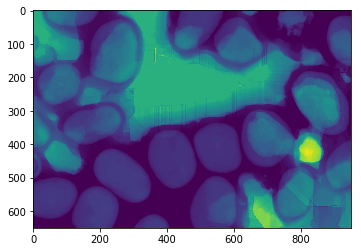

In [51]:
base_path = config_czi["seg_path"]
img_seg_all = skio.imread(os.path.join(base_path,seg_name))
img_seg_all[ 0,:,:] = 0
img_seg_all[-1,:,:] = 0
plt.imshow(img_seg_all.mean(axis=0))

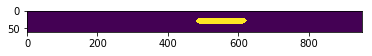

In [52]:
img_seg = img_seg_all.copy()
img_seg[img_seg!=cell_id] = 0
img_seg[img_seg==cell_id] = 1
plt.imshow(img_seg.max(axis=0))
plt.imshow(img_seg.max(axis=1))

In [53]:
print(img_seg.shape[0]*img_seg.shape[1]*img_seg.shape[2])
img_seg = label(img_seg)
print("#Comps:",np.unique(img_seg))
print("Sizes:",np.bincount(img_seg.flat,minlength=img_seg.max()))
largest_cc = 1 + np.argmax(np.bincount(img_seg.flat)[1:])
print("Largest CC:", largest_cc)

37050000
#Comps: [0 1 2 3]
Sizes: [36807052   242941        1        6]
Largest CC: 1


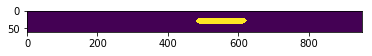

In [54]:
if img_seg.max() > 1:
    img_seg[img_seg!=largest_cc] = 0
    img_seg[img_seg>0] = 1
plt.imshow(img_seg.max(axis=0))
plt.imshow(img_seg.max(axis=1))

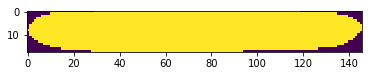

In [55]:
pxl_z, pxl_y, pxl_x = np.nonzero(img_seg)
img_seg_crop = img_seg[pxl_z.min():(pxl_z.max()+1),pxl_y.min():(pxl_y.max()+1),pxl_x.min():(pxl_x.max()+1)]
plt.imshow(img_seg_crop.max(axis=1))

(18, 152, 146) int64
(48, 152, 146)
int64 0 1


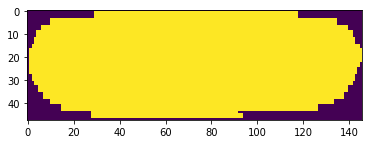

In [56]:
from skimage.transform import resize
nz, ny, nx = img_seg_crop.shape
nz = np.int((0.29/0.108)*nz)
print(img_seg_crop.shape, img_seg_crop.dtype)
img_seg_crop_resize = resize(image=img_seg_crop, output_shape=(nz,ny,nx), preserve_range=True, anti_aliasing=True, mode="constant")
img_seg_crop_resize = img_seg_crop_resize.astype(np.int64)
print(img_seg_crop_resize.shape)
plt.imshow(img_seg_crop_resize.max(axis=1))
print(img_seg_crop_resize.dtype,img_seg_crop_resize.min(),img_seg_crop_resize.max())

In [57]:
from aicsfeature.extractor import common
df_origin = common.get_shape_features(seg=img_seg_crop)
df_resize = common.get_shape_features(seg=img_seg_crop_resize)
print(df_origin,df_resize)

{'volume': 242941, 'surface_area': 31414, 'shape_1st_axis_x': 0.5289785791971957, 'shape_1st_axis_y': 0.8486074814525685, 'shape_1st_axis_z': -0.006856031887668011, 'shape_2nd_axis_x': 0.8486226469302784, 'shape_2nd_axis_y': -0.5289096055403412, 'shape_2nd_axis_z': 0.009707331466915485, 'shape_3rd_axis_x': -0.004611492986485924, 'shape_3rd_axis_y': 0.010953154335116405, 'shape_3rd_axis_z': 0.9999293787775948, 'shape_1st_axis_length': 160.5607288388822, 'shape_2nd_axis_length': 140.76815203234992, 'shape_3rd_axis_length': 17.543562095475192, 'shape_1st_eigenvalue': 19.04635045554496, 'shape_2nd_eigenvalue': 1051.929789549034, 'shape_3rd_eigenvalue': 1439.1015686761912, 'shape_meridional_eccentricity': 0.9999124150124206, 'shape_equator_eccentricity': 0.9998360710577113, 'shape_sphericity': 0.5993696688042232} {'volume': 595268, 'surface_area': 46077, 'shape_1st_axis_x': 0.5429851836642392, 'shape_1st_axis_y': 0.8394840787609312, 'shape_1st_axis_z': -0.020822387663836064, 'shape_2nd_axis

In [43]:
import javabridge as jv, bioformats as bf
jv.start_vm(class_path=bf.JARS, max_heap_size='4G')

def get_stack_from_series_id(czi_path, channel, series_id, dim):

    # Extraction a series from multi-position CZI

    img_raw = []
    for slice in range(dim[0]):
        img_raw.append(bf.load_image(path=czi_path, series=series_id, c=channel, z=slice, t=0, rescale=False))
    img_raw = np.array(img_raw).reshape(*dim)

    return img_raw

In [44]:
czi_path = os.path.join(config_czi["raw_path"],config_czi["raw_name"])
pxl_info = bf.OMEXML(bf.get_omexml_metadata(czi_path)).image(0).Pixels
nx = pxl_info.SizeX
ny = pxl_info.SizeY
nz = pxl_info.SizeZ

print("CZI:", config_czi["raw_name"], (nz,ny,nx))

# For each series

position = config_czi["ids_cell"][position]

# Parse series ID in the segmentation name
# First positiuon is 0, alhtough it is shown as Scene-01

print("\tSeries:",position["name"])

series_id = position["name"]
loc = series_id.find("Scene")

# First positiuon is 0, alhtough it is shown as Scene-01
series_id = np.int(series_id[(loc+6):(loc+8)]) - 1

img_raw = get_stack_from_series_id(czi_path=czi_path, channel=config_czi["dna_channel"], series_id=series_id, dim=(nz,ny,nx))

CZI: 20181005_R01_002.czi (60, 650, 950)
	Series: 20181005_R01_002-Scene-04-P34_seg_0.ome.tif


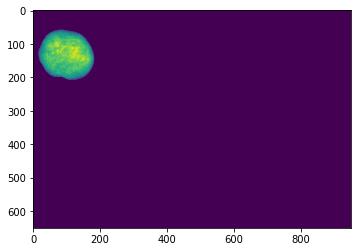

In [45]:
img_input = (img_raw*img_seg)
plt.imshow(img_input.mean(axis=0))

In [46]:
values = img_input[img_input>0]
values.mean()

868.2297008050602

In [47]:
skio.imsave("20181005_R01_002-Scene-04-P34_seg_0_cid_115.tif",img_input)

/home/matheus.viana/anaconda3/envs/qcb/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: 20181005_R01_002-Scene-04-P34_seg_0_cid_115.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
